In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


# Implementing ResNet-18

* ResNets (residual networks) won the ImageNet Large Scale Visual Recognition Challenge in 2015.

* We will use the [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which is composed of labeled images of clothes and accessories.

* We will resize the images in the dataset in order to preserve the ResNet-18 architecture, which was developed to classify colored images with $224 \times 224$ pixels.

* The following function is used to load the dataset and resize the images. You don't need to understand it for now.



In [ ]:
import torchvision

# You don't need to understand this function for now.
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2, pin_memory=True), # Using pinned memory
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)) # Using pinned memory

* Storing data in [pinned memory](https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/) speeds up training in a GPU.

In [ ]:
batch_size = 128 # Defines the batch size
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=(224, 224)) # Loads the fashion MNIST dataset. `train_iter` and `test_iter` are `DataLoader` objects.

100%|██████████| 26421880/26421880 [00:02<00:00, 11104643.26it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198494.84it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3711694.91it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6439688.93it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 128 images per batch. Each image is represented by a 1 x 224 x 224 tensor (number of channels x height x width). The images are grayscale, so there is a single channel.
print(y.size()) # 128 targets. Each target is a number between 0 and 9. The classification problem has 10 clases.

torch.Size([128, 1, 224, 224])
torch.Size([128])


* The following code displays some images from the first training batch.



Image 0 (dress):



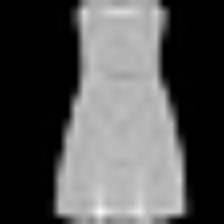


Image 1 (boot):



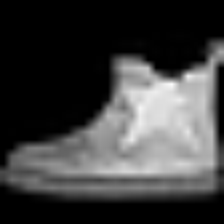


Image 2 (pullover):



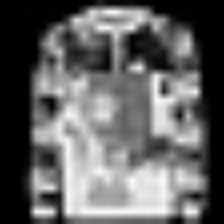

In [ ]:
from google.colab.patches import cv2_imshow

class_labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot'] # Pre-defined class labels

for i in range(3):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # Prints the index `i` and the label associated to the `i`-th image.
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # Converts and displays the `i`-th image in the batch.

## ResNet block

* The constructor for `ResNetBlock` should receive the number of input channels $c_i$, the number of output channels $c_o$, and the stride $s$.

* If $c_i = c_o$ and $s = 1$, the input image and the output image have the same shape $c_i \times h_i \times w_i$. In that case:
    1. The input image goes through a convolutional layer with $c_o$ convolutional filters, each with a $3 \times 3$ window, padding $1$, and stride $s$.
    2. The resulting image goes through a batch normalization layer for images and a rectified linear activation function.
    3. The resulting image goes through another convolutional layer with $c_o$ convolutional filters, each with a $3 \times 3$ window, padding $1$, and stride $1$.
    4. The resulting image goes through another batch normalization layer for images.
    5. The resulting image is added to the input image (skip connection).
    6. The resulting image goes through a rectified linear activation function.

* If $c_i \neq c_o$ or $s > 1$, the input image has shape $c_i \times h_i \times w_i$ and the output image has shape $c_o \times \lceil h_i/s \rceil \times \lceil w_i/s \rceil$. In that case:
    1. The input image goes through the first 4 steps described for the previous case.
    2. The input image also goes through a convolutional layer with $c_o$ convolutional filters, each with a $1 \times 1$ window and stride $s$.
    3. The image that results from step 1 is added to the image that results from step 2 (skip connection).
    4. The resulting image goes through a rectified linear activation function.

![ResNet block.](https://drive.google.com/uc?export=view&id=1yNH83-ndmKY0MAa94M9GNKdQU4OUdYAI)




In [ ]:
# TODO: Implement the class `ResNetBlock`
class ResNetBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = torch.nn.BatchNorm2d(output_channels)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channels)

        self.conv3 = None
        if (input_channels != output_channels) or (stride != 1):
            self.conv3 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride)

        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.conv3:
            out += self.conv3(x)
        else:
            out += x

        return self.relu2(out)

## Architecture

* The constructor of the `ResNetMacroblock` will receive the number of input channels and a boolean variable that indicates whether it is the first macroblock in the ResNet18 architecture (whose output shape matches the input shape).

* The following image summarizes the ResNet-18 architecture.

![ResNet-18 architecture.](https://drive.google.com/uc?export=view&id=1QTqgZHKRYV_engdzG7ZpsJdRPEzri_ab)

* The input image goes through a convolutional layer with $64$ convolutional filters, each with a $7 \times 7$ window, padding $3$, and stride $2$.

* The resulting image goes through a batch normalization layer for images and a rectified linear activation function.

* The resulting image goes through a max-pooling layer with $3 \times 3$ windows, padding $1$, and stride $2$.

* The resulting image goes through a sequence of four **ResNet macroblocks**, each of which is composed of $2$ ResNet blocks. In total, there are 8 ResNet blocks.

* The first ResNet block in each ResNet macroblock employs stride $2$, which requires the input image to go through a convolutional layer with $1 \times 1$ windows and stride $2$. Because the input image and the output image will necessarily have different shapes, this block also uses the opportunity to double the number of channels.

* Exceptionally, the first ResNet block in the first ResNet macroblock does not employ a convolutional layer with $1 \times 1$ windows. Therefore, its input image and output image will necessarily have the same shape.

* The image resulting from the sequence of four ResNet macroblocks has each of its $512$ channels averaged, resulting in a $512$-dimensional vector that goes through a single fully connected layer to produce a $q$-dimensional vector of logits, where $q$ is the number of classes in the classification problem.


In [ ]:
# TODO: Implement the class `ResNetMacroblock`
class ResNetMacroblock(torch.nn.Module):
    def __init__(self, input_channels, first_macroblock=False):
        super(ResNetMacroblock, self).__init__()

        s = 1 if first_macroblock else 2

        self.rb1 = ResNetBlock(input_channels, input_channels * s, stride=s)
        self.rb2 = ResNetBlock(input_channels * s, input_channels * s, stride=1)

    def forward(self, x):
        out = self.rb1(x)
        out = self.rb2(out)
        return out

In [ ]:
class ResNet18(torch.nn.Module):
    def __init__(self, num_outputs):
        super(ResNet18, self).__init__()

        self.num_outputs = num_outputs

        self.conv = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3) # Assuming 1 x 224 x 224 input images
        self.bn = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.rmb1 = ResNetMacroblock(64, first_macroblock=True)
        self.rmb2 = ResNetMacroblock(64)
        self.rmb3 = ResNetMacroblock(128)
        self.rmb4 = ResNetMacroblock(256)

        self.channel_avg = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(512, self.num_outputs)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.rmb1(out)
        out = self.rmb2(out)
        out = self.rmb3(out)
        out = self.rmb4(out)

        out = self.channel_avg(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out


In [ ]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10

model = ResNet18(10).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

ResNet18(
  (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (rmb1): ResNetMacroblock(
    (rb1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (rb2): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), st

## Loss function


In [ ]:
loss = torch.nn.CrossEntropyLoss()

## Optimization Algorithm


In [ ]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Evaluation


In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

# Example: 1 correct classification,
y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))

tensor(1.)


In [ ]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n)

In [ ]:
model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.1438833326101303. Testing accuracy: 0.14379999041557312.


* Executing the cell above takes several minutes in a CPU.


## Training

* Training your ResNet18 is optional. If you want to train your ResNet18 using Google Colab, make sure to select a GPU runtime (Runtime > Change Runtime type).

* **If you plan on using Google Colab for the programming project without a subscription, you should be very mindful about your GPU usage. For example, only change to a GPU runtime once you are ready to train your model.**



Epoch 1/10.
Training accuracy: 0.8371500372886658. Testing accuracy: 0.8246999979019165. Duration: 223.032s.

Epoch 2/10.
Training accuracy: 0.8867833614349365. Testing accuracy: 0.8644999861717224. Duration: 222.742s.

Epoch 3/10.
Training accuracy: 0.8998667001724243. Testing accuracy: 0.8804000020027161. Duration: 222.111s.

Epoch 4/10.
Training accuracy: 0.9241833686828613. Testing accuracy: 0.8946999907493591. Duration: 222.095s.

Epoch 5/10.
Training accuracy: 0.9253333210945129. Testing accuracy: 0.8946999907493591. Duration: 222.209s.

Epoch 6/10.
Training accuracy: 0.8977167010307312. Testing accuracy: 0.8673999905586243. Duration: 222.344s.

Epoch 7/10.
Training accuracy: 0.916866660118103. Testing accuracy: 0.875499963760376. Duration: 222.186s.

Epoch 8/10.
Training accuracy: 0.9539666771888733. Testing accuracy: 0.9041000008583069. Duration: 222.110s.

Epoch 9/10.
Training accuracy: 0.9613666534423828. Testing accuracy: 0.9041000008583069. Duration: 222.219s.

Epoch 10/10

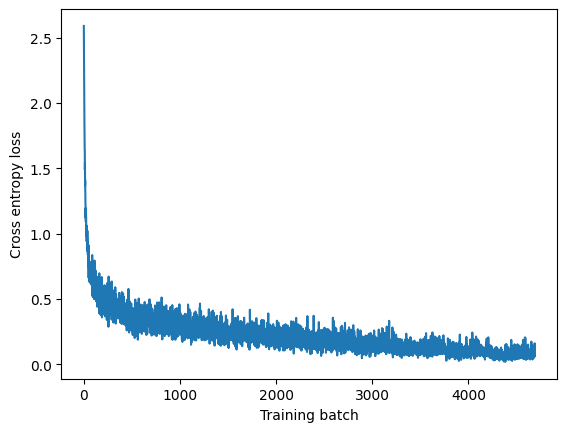

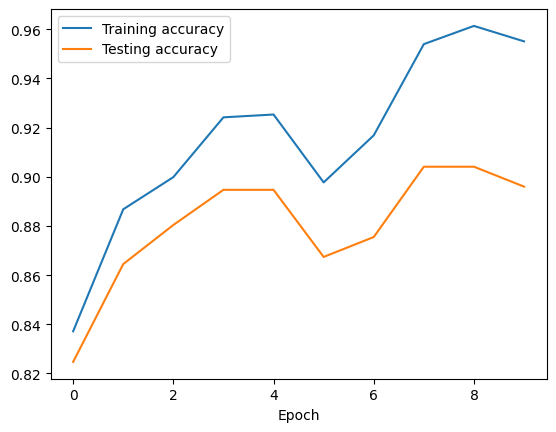

In [ ]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 10
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()